# Analysis of Voltage

In [47]:
import pandas as pd
import os
os.chdir("/home/admin123/timeseries")
fp = "ln_hpc.txt"
df = pd.read_csv(fp, sep = ";")
req_cols = ["Date", "Time", "Voltage"]
df = df[req_cols]
df["Timestamp"] = df["Date"] + " " + df["Time"]
df["Timestamp"] = pd.to_datetime(df["Timestamp"],format="%d/%m/%Y %H:%M:%S")
req_cols = ["Voltage", "Timestamp"]
df = df[req_cols]


In [48]:
df_pr = df[df["Voltage"] == '?']

In [49]:
df_pr.head(20)

,Voltage,Timestamp
6839,?,2006-12-21 11:23:00
6840,?,2006-12-21 11:24:00
19724,?,2006-12-30 10:08:00
19725,?,2006-12-30 10:09:00
41832,?,2007-01-14 18:36:00
61909,?,2007-01-28 17:13:00
98254,?,2007-02-22 22:58:00
98255,?,2007-02-22 22:59:00
142588,?,2007-03-25 17:52:00
190497,?,2007-04-28 00:21:00


In [50]:
df_pr.dtypes

Voltage              object
Timestamp    datetime64[ns]
dtype: object

## Observation:
Frequent data errors occur. Let us aggregate at hourly intervals and see if the data quality is better. We will remove the problematic records

In [51]:
df["Voltage"] = df[- (df["Voltage"] == "?")]
df["Voltage"] = df["Voltage"].astype('float')
df = df.set_index("Timestamp")
hourly_voltage = df.groupby(pd.Grouper(freq='H')).mean()


In [52]:
df_prh = hourly_voltage[(hourly_voltage.isnull())]


In [53]:
df_prh.head()

,Voltage
Timestamp,
2006-12-16 17:00:00,NaN
2006-12-16 18:00:00,NaN
2006-12-16 19:00:00,NaN
2006-12-16 20:00:00,NaN
2006-12-16 21:00:00,NaN


## Observation
Let us determine the number problematic data collection days in the data 

In [54]:
df_prh.loc[:,"Timestamp"] = df_prh.index.values
num_problem_days = len(df_prh["Timestamp"].dt.date.unique())

In [55]:
num_problem_days

1442

In [56]:
from fbprophet import Prophet
hourly_voltage = hourly_voltage.dropna()

In [57]:
hourly_voltage.tail()

,Voltage
Timestamp,
2010-11-26 17:00:00,237.069667
2010-11-26 18:00:00,237.531833
2010-11-26 19:00:00,236.741000
2010-11-26 20:00:00,239.396000
2010-11-26 21:00:00,239.690000


In [58]:
m = Prophet()
hourly_voltage.loc[:, "ds"] = hourly_voltage.index.values
hourly_voltage.rename(columns = {'Voltage': 'y'}, inplace = True)
test_df = hourly_voltage.tail(72)
trng_df = hourly_voltage.head(hourly_voltage.shape[0] - 72)

In [44]:
hourly_voltage.head()

,y,ds
Timestamp,,
2006-12-16 17:00:00,234.643889,2006-12-16 17:00:00
2006-12-16 18:00:00,234.580167,2006-12-16 18:00:00
2006-12-16 19:00:00,233.232500,2006-12-16 19:00:00
2006-12-16 20:00:00,234.071500,2006-12-16 20:00:00
2006-12-16 21:00:00,237.158667,2006-12-16 21:00:00


In [59]:
m.fit(trng_df)

In [60]:
trng_df.shape[0]

34096

In [76]:
future_data = m.make_future_dataframe(periods=72)

In [63]:
forecast_data = m.predict(future_data)

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline 
test_df.shape[0]

72

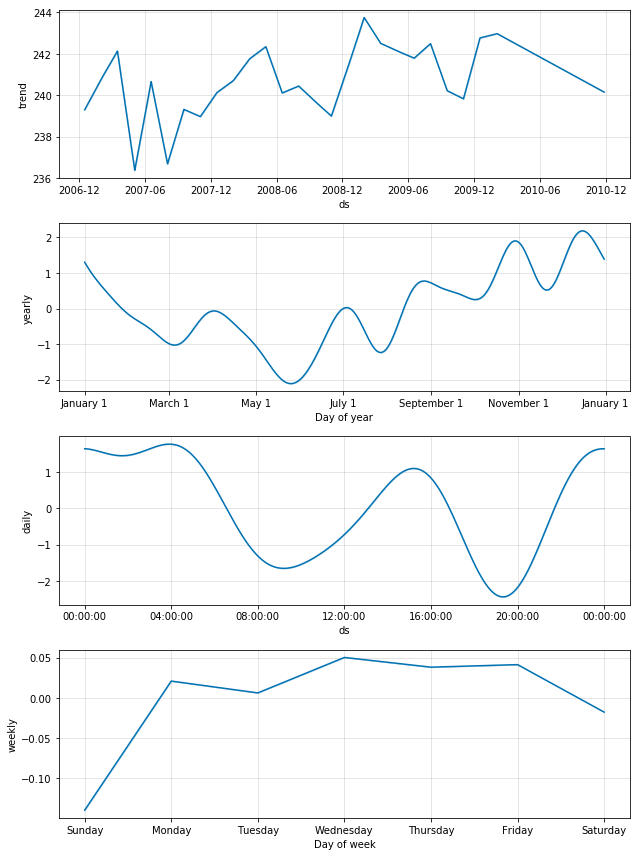

In [78]:
fig = m.plot_components(forecast_data)

In [83]:
preds = forecast_data["yhat"].tail(72)

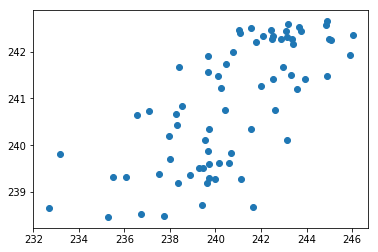

In [86]:
plt.scatter(test_df["y"], preds)

In [90]:
err = test_df["y"].values - preds

(array([ 2.,  0.,  3.,  4., 10., 12., 17., 13.,  6.,  5.]),
 array([-6.64289683, -5.57944159, -4.51598635, -3.45253111, -2.38907587,
        -1.32562062, -0.26216538,  0.80128986,  1.8647451 ,  2.92820034,
         3.99165558]),
 <a list of 10 Patch objects>)

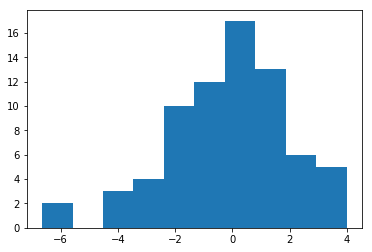

In [92]:
plt.hist(err)

In [95]:
import numpy as np
np.mean(err)

-0.15768343923305472